<a href="https://colab.research.google.com/github/harshvardhanhub/Detecting-Click-Fraud-in-Online-Advertising/blob/main/FinalYearProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# **DEFINE**

In [6]:
# Define additional classifiers
random_forest_classifier = RandomForestClassifier()
svm_classifier = SVC()
logistic_regression_classifier = LogisticRegression()


In [7]:
# Define a dictionary of classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'Random Forest': random_forest_classifier,
    'SVM': svm_classifier,
    'Logistic Regression': logistic_regression_classifier
}


In [8]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [9]:
dtypes = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

train_sample = pd.read_csv('/content/train_sample.csv',dtype=dtypes,usecols=colnames)


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
len(train_sample)

100000

In [12]:
train_sample.memory_usage()

Index               128
ip               200000
app              200000
device           200000
os               200000
channel          200000
click_time       800000
is_attributed    100000
dtype: int64

In [13]:
# space used by training data
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 1.812103271484375 MB


In [14]:
train_sample.head()

,ip,app,device,os,channel,click_time,is_attributed
0,22004,12,1,13,497,2017-11-07 09:30:38,0
1,40024,25,1,17,259,2017-11-07 13:40:27,0
2,35888,12,1,19,212,2017-11-07 18:05:24,0
3,29048,13,1,13,477,2017-11-07 04:58:08,0
4,2877,12,1,1,178,2017-11-09 09:00:09,0


# **# Balancing Dataset from Imbalance**

In [15]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


In [16]:
X = train_sample.drop(columns=['is_attributed'])
y = train_sample['is_attributed']


In [17]:
# Instantiate RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Resample the dataset
X_balanced_over, y_balanced_over = oversampler.fit_resample(X, y)


In [18]:
# Instantiate RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

# Resample the dataset
X_balanced_under, y_balanced_under = undersampler.fit_resample(X, y)


In [19]:
# Before Balancing (Unbalanced Dataset)
print("Original Dataset Class Distribution:")
print(train_sample['is_attributed'].value_counts())

# After Balancing (Balanced Dataset)
print("Balanced Dataset Class Distribution (After Oversampling):")
print(y_balanced_over.value_counts())  # Assuming 'y_balanced_over' contains the balanced target variable after oversampling

print("Balanced Dataset Class Distribution (After Undersampling):")
print(y_balanced_under.value_counts())  # Assuming 'y_balanced_under' contains the balanced target variable after undersampling


Original Dataset Class Distribution:
is_attributed
0    99773
1      227
Name: count, dtype: int64
Balanced Dataset Class Distribution (After Oversampling):
is_attributed
0    99773
1    99773
Name: count, dtype: int64
Balanced Dataset Class Distribution (After Undersampling):
is_attributed
0    227
1    227
Name: count, dtype: int64


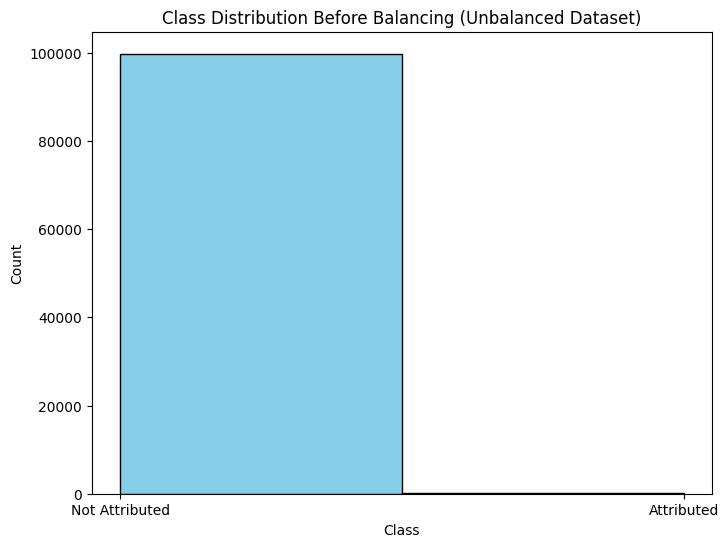

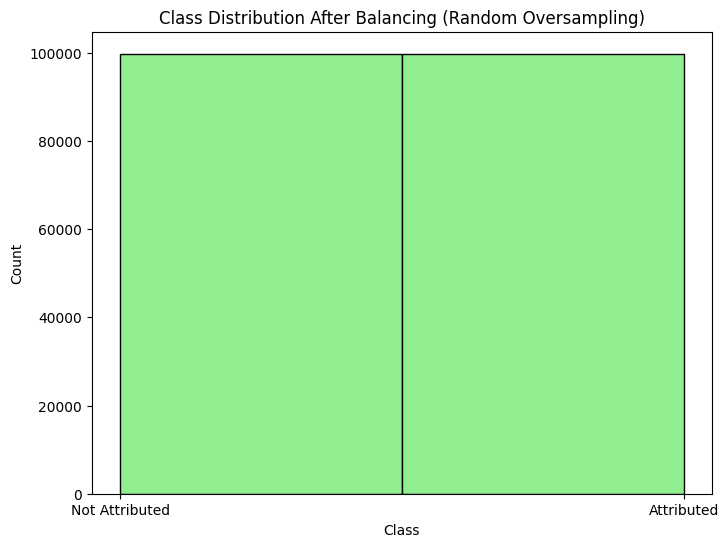

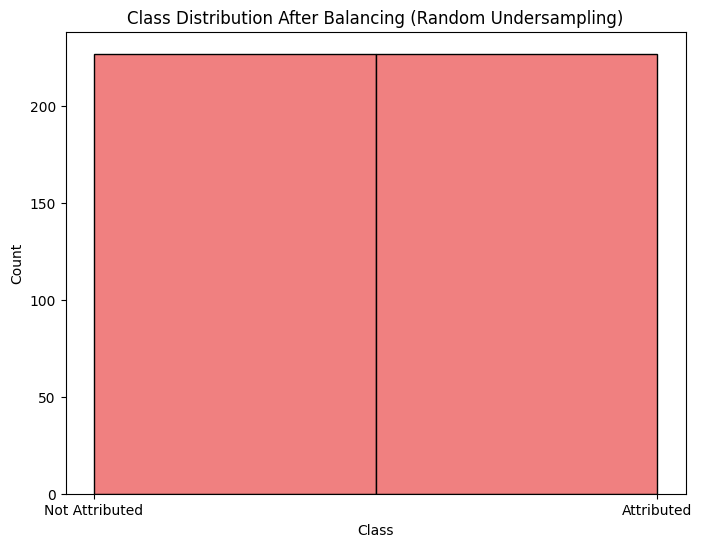

In [20]:
import matplotlib.pyplot as plt

# Before Balancing (Unbalanced Dataset)
plt.figure(figsize=(8, 6))
plt.hist(train_sample['is_attributed'], bins=2, color='skyblue', edgecolor='black')
plt.title('Class Distribution Before Balancing (Unbalanced Dataset)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Attributed', 'Attributed'])
plt.show()

# After Balancing (Balanced Dataset)
plt.figure(figsize=(8, 6))
plt.hist(y_balanced_over, bins=2, color='lightgreen', edgecolor='black')
plt.title('Class Distribution After Balancing (Random Oversampling)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Attributed', 'Attributed'])
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(y_balanced_under, bins=2, color='lightcoral', edgecolor='black')
plt.title('Class Distribution After Balancing (Random Undersampling)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Attributed', 'Attributed'])
plt.show()


In [21]:
# space used by training data
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 1.812103271484375 MB


# **Exploring the Data - Univariate Analysis**

Let's now understand and explore the data. Let's start with understanding the size and data types of the train_sample data.

In [22]:
# look at non-null values, number of entries etc.
# there are no missing values
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             100000 non-null  uint16
 1   app            100000 non-null  uint16
 2   device         100000 non-null  uint16
 3   os             100000 non-null  uint16
 4   channel        100000 non-null  uint16
 5   click_time     100000 non-null  object
 6   is_attributed  100000 non-null  uint8 
dtypes: object(1), uint16(5), uint8(1)
memory usage: 1.8+ MB


In [23]:
# Basic exploratory analysis

# Number of unique values in each column

def fraction_unique(x):
    return len(train_sample[x].unique())

number_unique_vals = {x : fraction_unique(x) for x in train_sample.columns}
number_unique_vals

{'ip': 28470,
 'app': 161,
 'device': 100,
 'os': 130,
 'channel': 161,
 'click_time': 80350,
 'is_attributed': 2}

In [24]:
# All columns apart from click time are originally int type,
# though note that they are all actually categorical
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
click_time       object
is_attributed     uint8
dtype: object

There are certain 'apps' which have quite high number of instances/rows (each row is a click). The plot below shows this.

<Axes: xlabel='app', ylabel='count'>

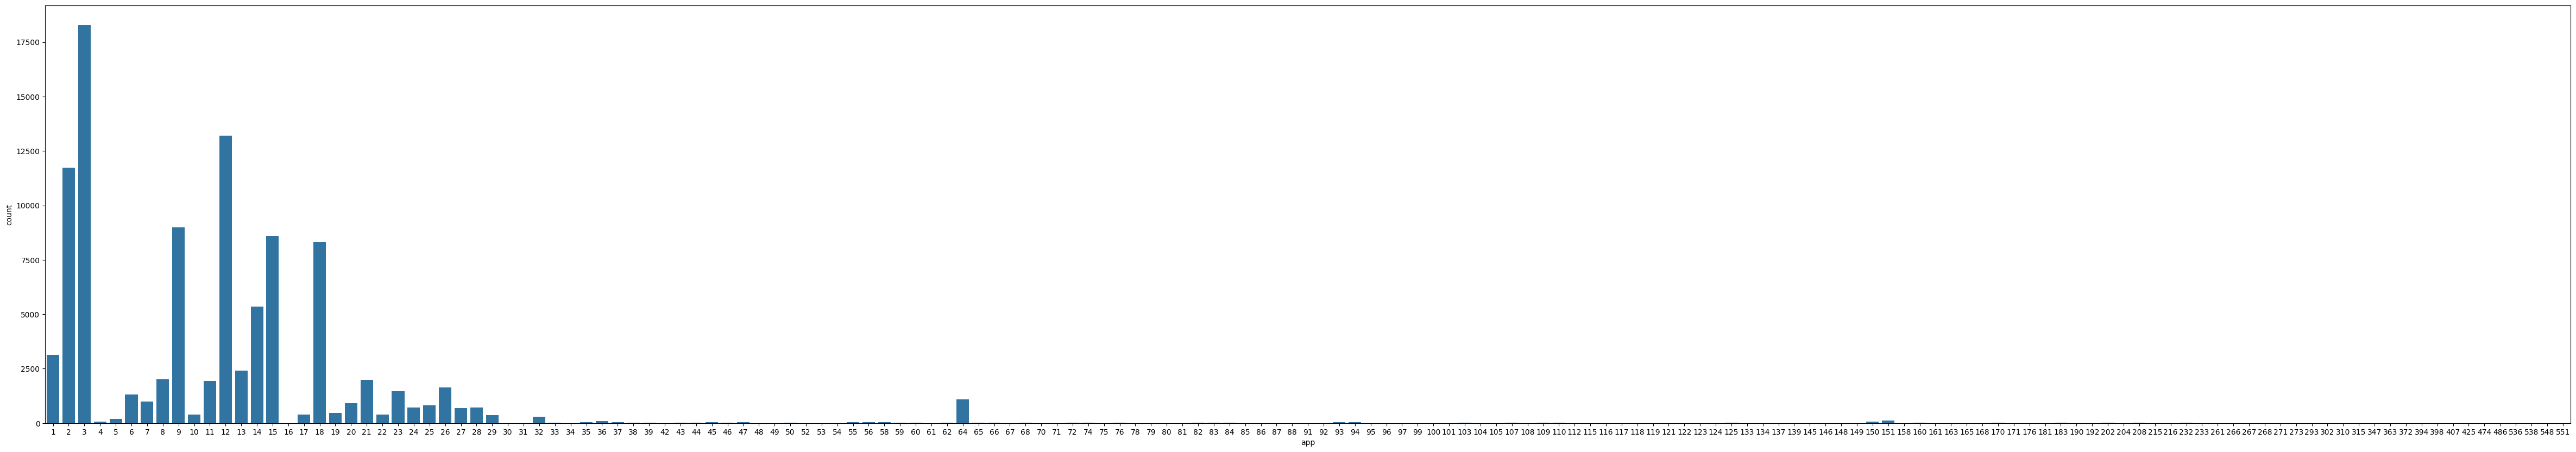

In [25]:
# distribution of 'app'
# some 'apps' have a disproportionately high number of clicks (>15k), and some are very rare (3-4)
plt.figure(figsize=(60,10))
sns.countplot(x="app",data=train_sample)


<Axes: xlabel='device', ylabel='count'>

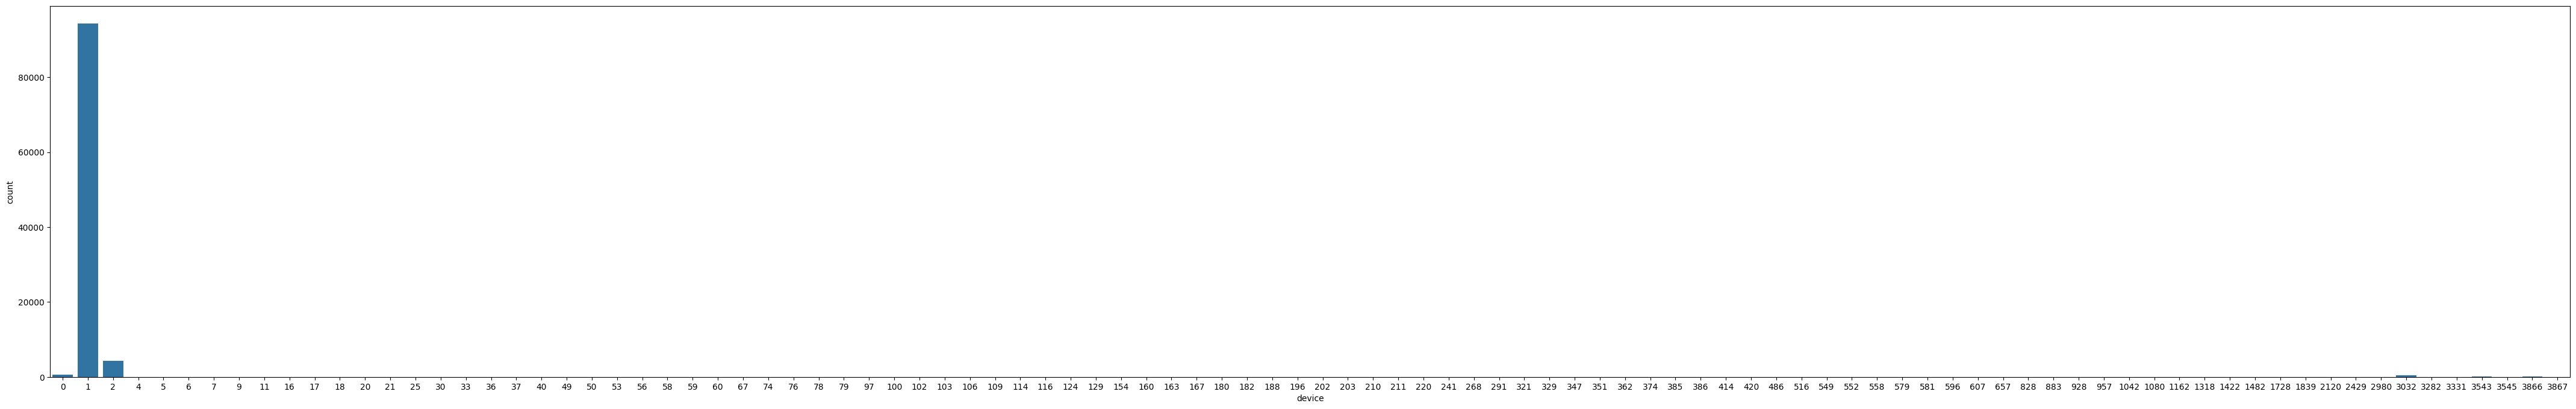

In [26]:
# distribution of 'device'
# this is expected because a few popular devices are used heavily
plt.figure(figsize=(54, 8))
sns.countplot(x="device", data=train_sample)

<Axes: xlabel='channel', ylabel='count'>

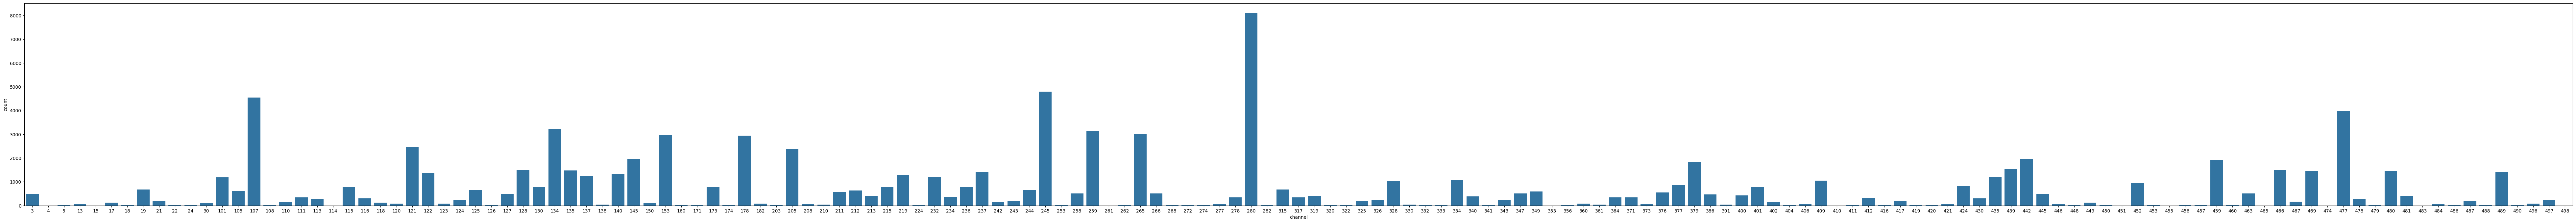

In [27]:
# channel: various channels get clicks in comparable quantities
plt.figure(figsize=(100, 8))
sns.countplot(x="channel", data=train_sample)

<Axes: xlabel='os', ylabel='count'>

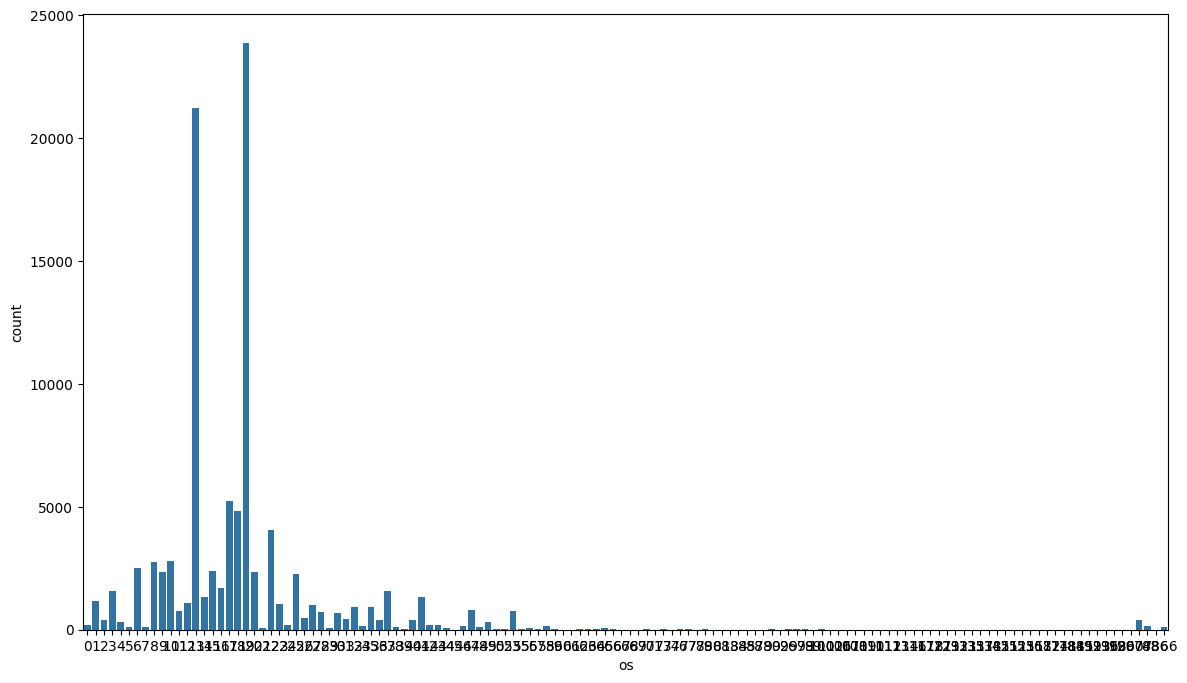

In [28]:
# os: there are a couple commos OSes (android and ios?), though some are rare and can indicate suspicion
plt.figure(figsize=(14, 8))
sns.countplot(x="os", data=train_sample)

Let's now look at the distribution of the target variable 'is_attributed'.

In [29]:
# target variable distribution
100 * (train_sample['is_attributed'].astype('object').value_counts()/len(train_sample.index))

is_attributed
0    99.773
1     0.227
Name: count, dtype: float64

italicized textExploring the Data - Segmented Univariate Analysis

In [30]:
# plot the average of 'is_attributed', or 'download rate'
# with app (clearly this is non-readable)

app_target = train_sample.groupby('app').is_attributed.agg(['mean','count'])
app_target

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1


This is clearly non-readable, so let's first get rid of all the apps that are very rare (say which comprise of less than 20% clicks) and plot the rest

In [31]:
frequent_apps = train_sample.groupby('app').size().reset_index(name='count')
frequent_apps = frequent_apps[frequent_apps['count']>frequent_apps['count'].quantile(0.80)]
frequent_apps = frequent_apps.merge(train_sample,on='app',how='inner')
frequent_apps.head()

,app,count,ip,device,os,channel,click_time,is_attributed
0,1,3135,17059,1,17,135,2017-11-09 01:17:58,0
1,1,3135,52432,1,13,115,2017-11-07 17:22:52,0
2,1,3135,23706,1,27,124,2017-11-07 09:37:21,0
3,1,3135,58458,1,19,101,2017-11-09 14:27:57,0
4,1,3135,34067,1,15,134,2017-11-07 15:06:06,0


<Axes: xlabel='count', ylabel='app'>

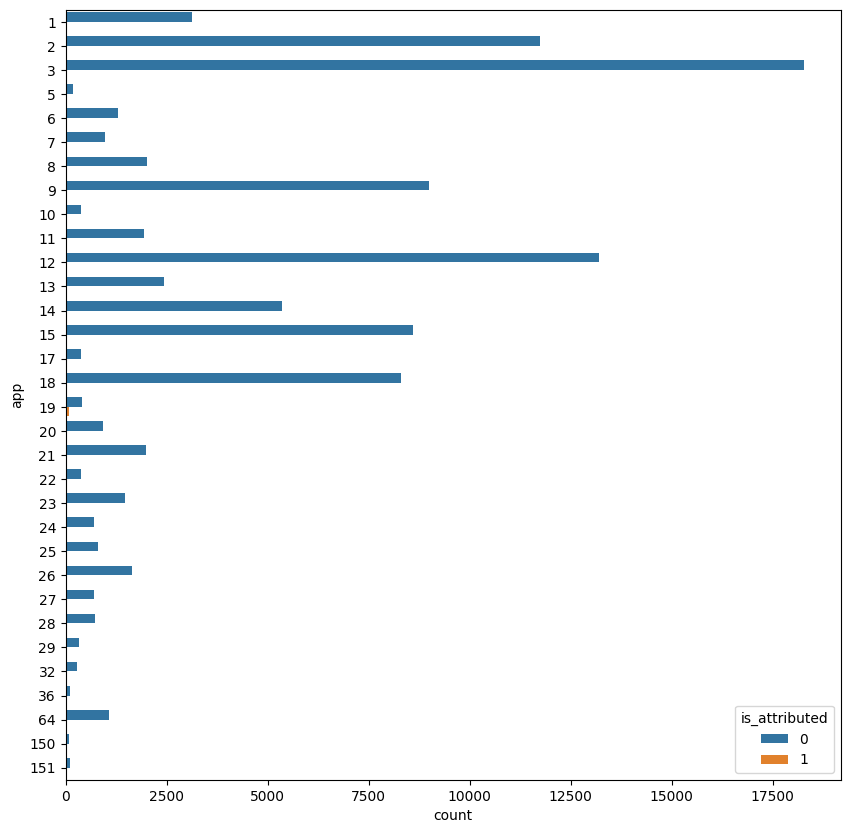

In [32]:
plt.figure(figsize=(10,10))
sns.countplot(y="app", hue="is_attributed", data=frequent_apps)

We can do lots of other interesting ananlysis with the existing features. For now, let's create some new features which will probably improve the model.

Feature Engineering

Let's now derive some new features from the existing ones. There are a number of features one can extract from click_time itself, and by grouping combinations of IP with other features.

# *** Datetime Based Features***

In [33]:
# Creating datetime variables
# takes in a df, adds date/time based columns to it, and returns the modified df

def timeFeatures(df):
    # Derive new features using the click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['month'] = df['datetime'].dt.month
    df['hour'] =df['datetime'].dt.hour
    return df


In [34]:
# creating new datetime variables and dropping the old ones
train_sample = timeFeatures(train_sample)
train_sample.drop(['click_time','datetime'], axis=1, inplace=True)
train_sample.head()


,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,311,11,9
1,40024,25,1,17,259,0,1,311,11,13
2,35888,12,1,19,212,0,1,311,11,18
3,29048,13,1,13,477,0,1,311,11,4
4,2877,12,1,1,178,0,3,313,11,9


In [35]:
# datatypes
# note that by default the new datetime variables are int64
train_sample.dtypes


ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week       int32
day_of_year       int32
month             int32
hour              int32
dtype: object

In [36]:
# memory used by training data
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 2.575042724609375 MB


In [37]:
# lets convert the variables back to lower dtype again
int_vars = ['app', 'device', 'os', 'channel', 'day_of_week','day_of_year', 'month', 'hour']
train_sample[int_vars] = train_sample[int_vars].astype('uint16')

In [38]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week      uint16
day_of_year      uint16
month            uint16
hour             uint16
dtype: object

In [39]:
# space used by training data
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 1.812103271484375 MB


# **IP Grouping Based Features**

Let's now create some important features by grouping IP addresses with features such as os, channel, hour, day etc. Also, count of each IP address will also be a feature.

Note that though we are deriving new features by grouping IP addresses, using IP adress itself as a features is not a good idea. This is because (in the test data) if a new IP address is seen, the model will see a new 'category' and will not be able to make predictions (IP is a categorical variable, it has just been encoded with numbers).

In [40]:
# number of clicks by count of IP address
# note that we are explicitly asking pandas to re-encode the aggregated features
# as 'int16' to save memory
ip_count = train_sample.groupby('ip').size().reset_index(name='ip_count').astype('int16')
ip_count.head()


,ip,ip_count
0,8,1
1,9,1
2,10,3
3,14,1
4,16,6


We can now merge this dataframe with the original training df. Similarly, we can create combinations of various features such as ip_day_hour (count of ip-day-hour combinations), ip_hour_channel, ip_hour_app, etc.

The following function takes in a dataframe and creates these features.

In [41]:
# creates groupings of IP addresses with other features and appends the new features to the df

def grouped_features(df):
    # ip_count
    ip_count = df.groupby('ip').size().reset_index(name='ip_count').astype('uint16')
    ip_day_hour = df.groupby(['ip','day_of_week','hour']).size().reset_index(name='ip_day_hour').astype('uint16')
    ip_hour_channel = df[['ip','hour','channel']].groupby(['ip','hour','channel']).size().reset_index(name='ip_hour_channel').astype('uint16')
    ip_hour_os = df.groupby(['ip', 'hour', 'os']).channel.count().reset_index(name='ip_hour_os').astype('uint16')
    ip_hour_app = df.groupby(['ip', 'hour', 'app']).channel.count().reset_index(name='ip_hour_app').astype('uint16')
    ip_hour_device = df.groupby(['ip', 'hour', 'device']).channel.count().reset_index(name='ip_hour_device').astype('uint16')

    # merge the new aggregated features with the df
    df = pd.merge(df, ip_count, on='ip', how='left')
    del ip_count
    df = pd.merge(df, ip_day_hour, on=['ip', 'day_of_week', 'hour'], how='left')
    del ip_day_hour
    df = pd.merge(df, ip_hour_channel, on=['ip', 'hour', 'channel'], how='left')
    del ip_hour_channel
    df = pd.merge(df, ip_hour_os, on=['ip', 'hour', 'os'], how='left')
    del ip_hour_os
    df = pd.merge(df, ip_hour_app, on=['ip', 'hour', 'app'], how='left')
    del ip_hour_app
    df = pd.merge(df, ip_hour_device, on=['ip', 'hour', 'device'], how='left')
    del ip_hour_device

    return df

In [42]:
train_sample = grouped_features(train_sample)


In [43]:
train_sample.head()


,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,22004,12,1,13,497,0,1,311,11,9,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,311,11,13,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,311,11,18,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,311,11,4,3,1,1,1,1,1
4,2877,12,1,1,178,0,3,313,11,9,4,1,1,1,1,1


In [44]:
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 2.956512451171875 MB


In [45]:
import gc
# garbage collect (unused) object
gc.collect()

458

# **Modelling**

Let's now build models to predict the variable is_attributed (downloaded). We'll try the several variants of boosting (adaboost, gradient boosting and XGBoost), tune the hyperparameters in each model and choose the one which gives the best performance.

In the Kaggle competition, the metric for model evaluation is area under the ROC curve.

In [46]:
# create x and y train
X = train_sample.drop('is_attributed',axis=1)
y = train_sample[['is_attributed']]

# split data into train and test/validation sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=101)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(80000, 15)
(80000, 1)
(20000, 15)
(20000, 1)


In [47]:
# check the average download rates in train and test data, should be comparable
print(y_train.mean())
print(y_test.mean())

is_attributed    0.002275
dtype: float64
is_attributed    0.00225
dtype: float64


# **AdaBoost Classifier**

In [48]:
# adaboost classifier with max 600 decision tress of depth=2
# learning_rate/shrinkage = 1.5

# base estimator
tree = DecisionTreeClassifier(max_depth=2)

# adaboost with the tree as base estimator
adaboost_model_1 = AdaBoostClassifier(base_estimator=tree,
                                     n_estimators=600,
                                     learning_rate=1.5,
                                     algorithm="SAMME")

In [49]:
# fit
adaboost_model_1.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=1.5, n_estimators=600)

In [50]:
# predictions
# the second column represents the probability of click resulting in a download

predictions = adaboost_model_1.predict_proba(X_test)
predictions[:10]

array([[0.54049582, 0.45950418],
       [0.53588662, 0.46411338],
       [0.53885559, 0.46114441],
       [0.52427816, 0.47572184],
       [0.52018053, 0.47981947],
       [0.5308397 , 0.4691603 ],
       [0.53055748, 0.46944252],
       [0.54126954, 0.45873046],
       [0.52347347, 0.47652653],
       [0.51624249, 0.48375751]])

In [51]:
# metrics : AUC
metrics.roc_auc_score(y_test,predictions[:,1])

0.9523839750549848

# **AdaBoost - Hyperparameter Tuning**

In [52]:
# parameter grid
param_grid = {"base_estimator__max_depth" : [2,5],
             "n_estimators" : [200,400,600]
             }

In [53]:
# base estimator
tree = DecisionTreeClassifier()

# adaboost with the tree as base estimator
# learning rate is arbitrality set to 0.6

ABC = AdaBoostClassifier(base_estimator=tree,
                        learning_rate=0.6,
                        algorithm="SAMME")

In [54]:
# run grid search
folds = 3
grid_search_ABC = GridSearchCV(ABC,
                              cv=folds,
                              param_grid=param_grid,
                              scoring='roc_auc',
                              return_train_score=True,
                              verbose=1)

In [55]:
# fit
grid_search_ABC.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(),
                                          learning_rate=0.6),
             param_grid={'base_estimator__max_depth': [2, 5],
                         'n_estimators': [200, 400, 600]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [56]:
# cv results
cv_results = pd.DataFrame(grid_search_ABC.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,11.172356,0.247207,0.324605,0.081417,2,200,"{'base_estimator__max_depth': 2, 'n_estimators...",0.926966,0.975725,0.955801,0.952831,0.020017,1,0.996306,0.995094,0.996461,0.995954,0.000611
1,21.362947,0.422580,0.535151,0.010473,2,400,"{'base_estimator__max_depth': 2, 'n_estimators...",0.920643,0.974585,0.956496,0.950575,0.022416,2,0.997991,0.996683,0.997996,0.997556,0.000618
2,31.948809,0.710572,0.785085,0.003959,2,600,"{'base_estimator__max_depth': 2, 'n_estimators...",0.921720,0.973335,0.953955,0.949670,0.021288,3,0.998494,0.997923,0.998417,0.998278,0.000253
3,23.762914,0.263216,0.354066,0.017739,5,200,"{'base_estimator__max_depth': 5, 'n_estimators...",0.890651,0.943105,0.937250,0.923668,0.023469,4,1.000000,1.000000,1.000000,1.000000,0.000000
4,47.139584,0.310536,0.785648,0.156991,5,400,"{'base_estimator__max_depth': 5, 'n_estimators...",0.894133,0.931286,0.945146,0.923522,0.021537,5,1.000000,1.000000,1.000000,1.000000,0.000000
5,70.867735,0.503947,0.962961,0.012162,5,600,"{'base_estimator__max_depth': 5, 'n_estimators...",0.886686,0.940449,0.934049,0.920394,0.023978,6,1.000000,1.000000,1.000000,1.000000,0.000000


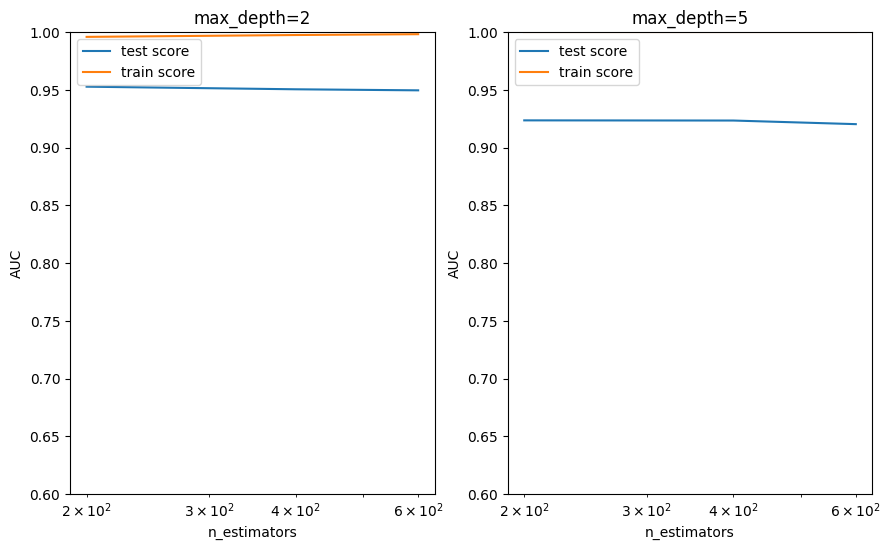

In [57]:
# plotting AUC with hyperparameter combinations

plt.figure(figsize=(16,6))
for n, depth in enumerate(param_grid['base_estimator__max_depth']):


    # subplot 1/n
    plt.subplot(1,3, n+1)
    depth_df = cv_results[cv_results['param_base_estimator__max_depth']==depth]

    plt.plot(depth_df["param_n_estimators"], depth_df["mean_test_score"])
    plt.plot(depth_df["param_n_estimators"], depth_df["mean_train_score"])
    plt.xlabel('n_estimators')
    plt.ylabel('AUC')
    plt.title("max_depth={0}".format(depth))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

The results above show that:

The ensemble with max_depth=5 is clearly overfitting (training auc is almost 1, while the test score is much lower)
At max_depth=2, the model performs slightly better (approx 95% AUC) with a higher test score

Thus, we should go ahead with max_depth=2 and n_estimators=200.

Note that we haven't experimented with many other important hyperparameters till now, such as learning rate, subsample etc., and the results might be considerably improved by tuning them. We'll next experiment with these hyperparameters.

In [58]:
# model performance on test data with chosen hyperparameters

# base estimator
tree = DecisionTreeClassifier(max_depth=2)

# adaboost with the tree as base estimator
# learning rate is arbitrarily set, we'll discuss learning_rate below
ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    n_estimators=200,
    algorithm="SAMME")

ABC.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.6, n_estimators=200)

In [59]:
# predict on test data
predictions = ABC.predict_proba(X_test)
predictions[:10]

array([[0.61058431, 0.38941569],
       [0.60742586, 0.39257414],
       [0.63265753, 0.36734247],
       [0.58758342, 0.41241658],
       [0.57045678, 0.42954322],
       [0.61162484, 0.38837516],
       [0.59403993, 0.40596007],
       [0.60805124, 0.39194876],
       [0.60362848, 0.39637152],
       [0.57654304, 0.42345696]])

In [60]:
# roc auc
metrics.roc_auc_score(y_test, predictions[:, 1])

0.960727748545338

# **Gradient Boosting Classifier**

In [61]:
# parameter grid
param_grid = {"learning_rate": [0.2, 0.6, 0.9],
              "subsample": [0.3, 0.6, 0.9]
             }

In [62]:
# adaboost with the tree as base estimator
GBC = GradientBoostingClassifier(max_depth=2, n_estimators=200)

In [63]:
# run grid search
folds = 3
grid_search_GBC = GridSearchCV(GBC,
                               cv = folds,
                               param_grid=param_grid,
                               scoring = 'roc_auc',
                               return_train_score=True,
                               verbose = 1)

grid_search_GBC.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(max_depth=2,
                                                  n_estimators=200),
             param_grid={'learning_rate': [0.2, 0.6, 0.9],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [64]:
cv_results = pd.DataFrame(grid_search_GBC.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,4.973032,0.469245,0.042404,0.000691,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.808588,0.757908,0.802052,0.789516,0.022509,3,0.788539,0.835737,0.782918,0.802398,0.023686
1,7.444022,0.494452,0.055492,0.017006,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.920836,0.924823,0.918805,0.921488,0.002500,1,0.943681,0.899250,0.930137,0.924356,0.018594
2,9.840021,0.117765,0.044784,0.002243,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.926055,0.828437,0.788714,0.847735,0.057706,2,0.964689,0.812383,0.792055,0.856376,0.077037
3,5.125006,0.495188,0.113797,0.103945,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.712095,0.760325,0.647198,0.706539,0.046351,5,0.676597,0.767619,0.637537,0.693918,0.054499
4,7.598724,0.447581,0.060043,0.015435,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.809830,0.780151,0.684789,0.758257,0.053344,4,0.823640,0.761181,0.698092,0.760971,0.051255


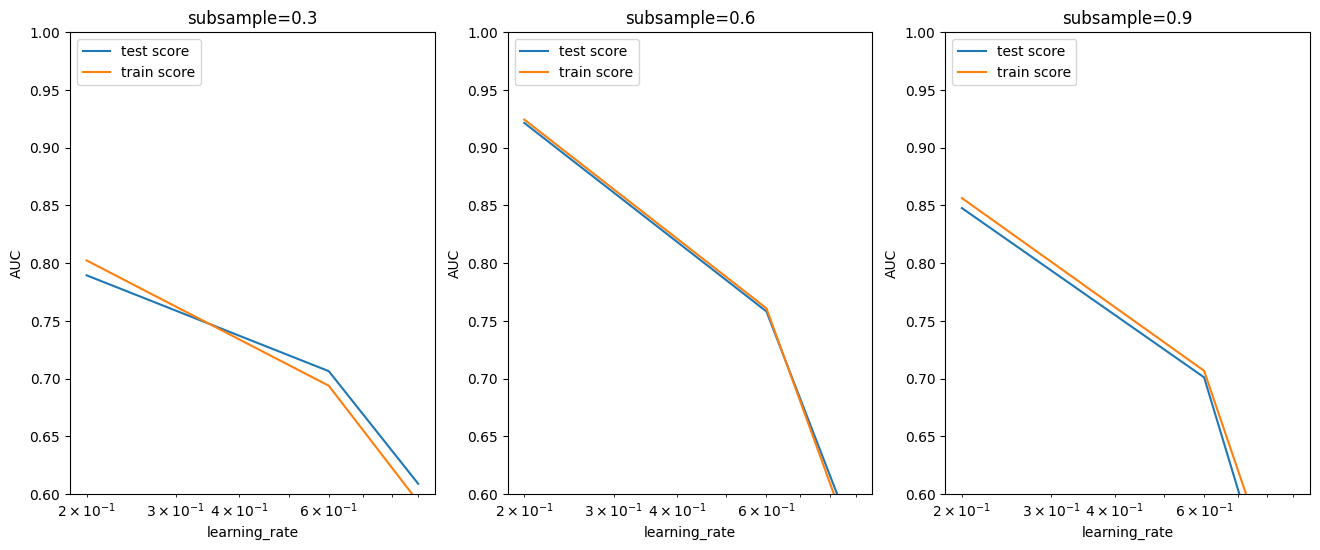

In [65]:
# # plotting
plt.figure(figsize=(16,6))


for n, subsample in enumerate(param_grid['subsample']):


    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

Gradient Boosting Classifier Accuracy: 0.9976
Gradient Boosting Classifier ROC AUC Score: 0.5331829950722459
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.33      0.07      0.11        45

    accuracy                           1.00     20000
   macro avg       0.67      0.53      0.55     20000
weighted avg       1.00      1.00      1.00     20000



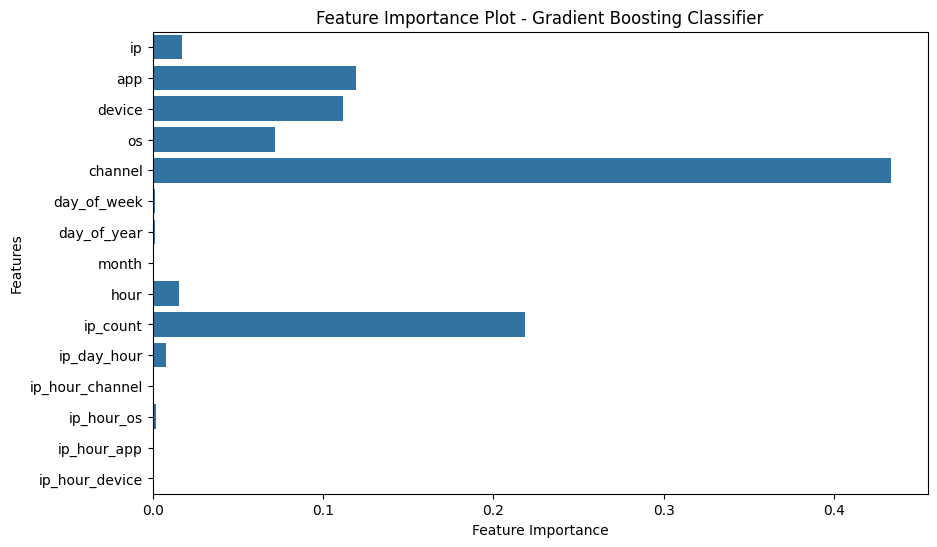

In [66]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Instantiate the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier()

# Fit the model on the training data
gb_classifier.fit(X_train, y_train)

# Make predictions on the test data
predictions_gb = gb_classifier.predict(X_test)

# Evaluate the model
accuracy_gb = accuracy_score(y_test, predictions_gb)
roc_auc_gb = roc_auc_score(y_test, predictions_gb)
classification_report_gb = classification_report(y_test, predictions_gb)

# Print the accuracy, ROC AUC, and classification report
print("Gradient Boosting Classifier Accuracy:", accuracy_gb)
print("Gradient Boosting Classifier ROC AUC Score:", roc_auc_gb)
print("Classification Report:")
print(classification_report_gb)

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x=gb_classifier.feature_importances_, y=X_train.columns)
plt.title('Feature Importance Plot - Gradient Boosting Classifier')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()


It is clear from the plot above that the model with a lower subsample ratio performs better, while those with higher subsamples tend to overfit.

Also, a lower learning rate results in less overfitting.

Confusion Matrix:

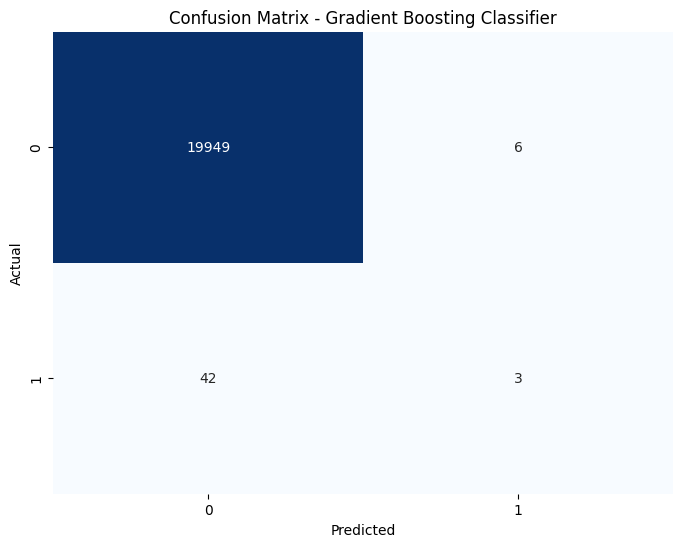

In [67]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm_gb = confusion_matrix(y_test, predictions_gb)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Gradient Boosting Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Receiver Operating Characteristic (ROC) Curve:

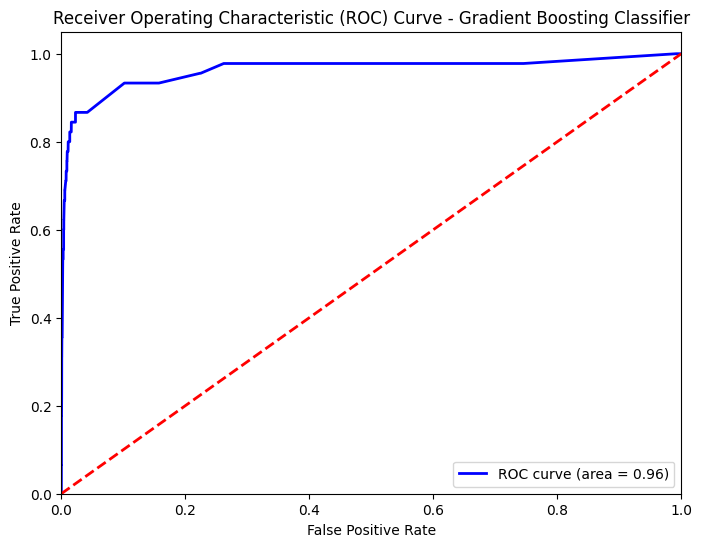

In [68]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute predicted probabilities
gb_probs = gb_classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_probs)
roc_auc_gb = roc_auc_score(y_test, gb_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_gb)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Gradient Boosting Classifier')
plt.legend(loc='lower right')
plt.show()


# **XGBoost (Extreme Gradient Boosting) Classifier**

In [69]:
# fit model on training data with default hyperparameters
model = XGBClassifier()
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [70]:
# make predictions for test data
# use predict_proba since we need probabilities to compute auc
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[9.9999762e-01, 2.3850384e-06],
       [9.9997681e-01, 2.3205019e-05],
       [9.9999285e-01, 7.1295767e-06],
       [9.9978524e-01, 2.1477159e-04],
       [9.9994248e-01, 5.7545258e-05],
       [9.9999696e-01, 3.0614756e-06],
       [9.9992359e-01, 7.6433542e-05],
       [9.9999708e-01, 2.9036298e-06],
       [9.9962950e-01, 3.7048370e-04],
       [9.9869585e-01, 1.3041229e-03]], dtype=float32)

In [71]:
# evaluate predictions
roc = metrics.roc_auc_score(y_test,y_pred[:,1])
print("AUC : %.2f%%" %(roc * 100.0))

AUC : 95.04%


The roc_auc in this case is about 0.95% with default hyperparameters. Let's try changing the hyperparameters

Let's now try tuning the hyperparameters using k-fold CV. We'll then use grid search CV to find the optimal values of hyperparameters.

In [72]:
# hyperparameter tuning with XGBoost
# creating a KFold object
folds = 3
# specify range of hyperparamaters
param_grid = {'learning_rate' : [0.2,0.6],
             'subsample' : [0.3,0.6,0.9]
             }
# specify model
xgb_model = XGBClassifier(max_depth=2,n_estimators=200)
# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model,
                       param_grid = param_grid,
                       scoring = 'roc_auc',
                       cv = folds,
                       verbose = 1,
                       return_train_score = True)

In [73]:
# fit the model
model_cv.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [74]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.643392,0.029008,0.046132,0.001313,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.939447,0.963060,0.953743,0.952083,0.009711,2,0.993420,0.982137,0.987524,0.987694,0.004608
1,0.622208,0.015581,0.056361,0.012484,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.929180,0.975357,0.965714,0.956750,0.019888,1,0.994989,0.990018,0.993550,0.992852,0.002088
2,0.580267,0.005155,0.047416,0.000551,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.918062,0.977776,0.955834,0.950557,0.024662,4,0.994057,0.990819,0.994390,0.993089,0.001611
3,2.569695,1.604860,0.113251,0.089308,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.931392,0.946245,0.945814,0.941150,0.006902,6,0.997588,0.993351,0.989338,0.993426,0.003368
4,0.612966,0.006896,0.046996,0.001348,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.929422,0.962755,0.962189,0.951456,0.015581,3,0.998950,0.998907,0.999362,0.999073,0.000205
5,0.570088,0.015468,0.053119,0.006631,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.914800,0.975916,0.955401,0.948706,0.025395,5,0.999544,0.998795,0.999682,0.999340,0.000390


In [75]:
# convert parameters to int for plotting on x-axis
cv_results['param_learning_rate'] = cv_results['param_learning_rate'].astype('float')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.643392,0.029008,0.046132,0.001313,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.939447,0.963060,0.953743,0.952083,0.009711,2,0.993420,0.982137,0.987524,0.987694,0.004608
1,0.622208,0.015581,0.056361,0.012484,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.929180,0.975357,0.965714,0.956750,0.019888,1,0.994989,0.990018,0.993550,0.992852,0.002088
2,0.580267,0.005155,0.047416,0.000551,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.918062,0.977776,0.955834,0.950557,0.024662,4,0.994057,0.990819,0.994390,0.993089,0.001611
3,2.569695,1.604860,0.113251,0.089308,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.931392,0.946245,0.945814,0.941150,0.006902,6,0.997588,0.993351,0.989338,0.993426,0.003368
4,0.612966,0.006896,0.046996,0.001348,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.929422,0.962755,0.962189,0.951456,0.015581,3,0.998950,0.998907,0.999362,0.999073,0.000205


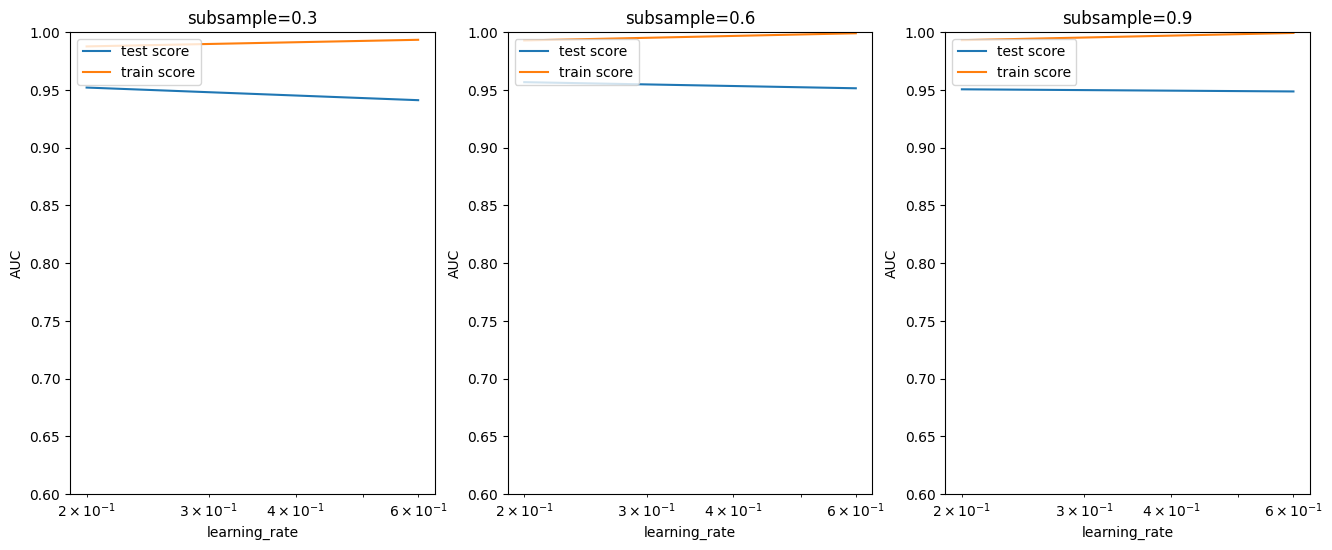

In [76]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6],
             'subsample': [0.3, 0.6, 0.9]}


for n, subsample in enumerate(param_grid['subsample']):


    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [77]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Instantiate the XGBoost classifier
xgb_model = XGBClassifier()

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
predictions_xgb = xgb_model.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, predictions_xgb)
classification_report_xgb = classification_report(y_test, predictions_xgb)

# Print the accuracy and classification report
print("XGBoost Classifier Accuracy:", accuracy_xgb)
print("Classification Report:")
print(classification_report_xgb)


XGBoost Classifier Accuracy: 0.9979
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.60      0.20      0.30        45

    accuracy                           1.00     20000
   macro avg       0.80      0.60      0.65     20000
weighted avg       1.00      1.00      1.00     20000



XGBoost Classifier Accuracy: 0.9979
XGBoost Classifier ROC AUC Score: 0.5998496617389125
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.60      0.20      0.30        45

    accuracy                           1.00     20000
   macro avg       0.80      0.60      0.65     20000
weighted avg       1.00      1.00      1.00     20000



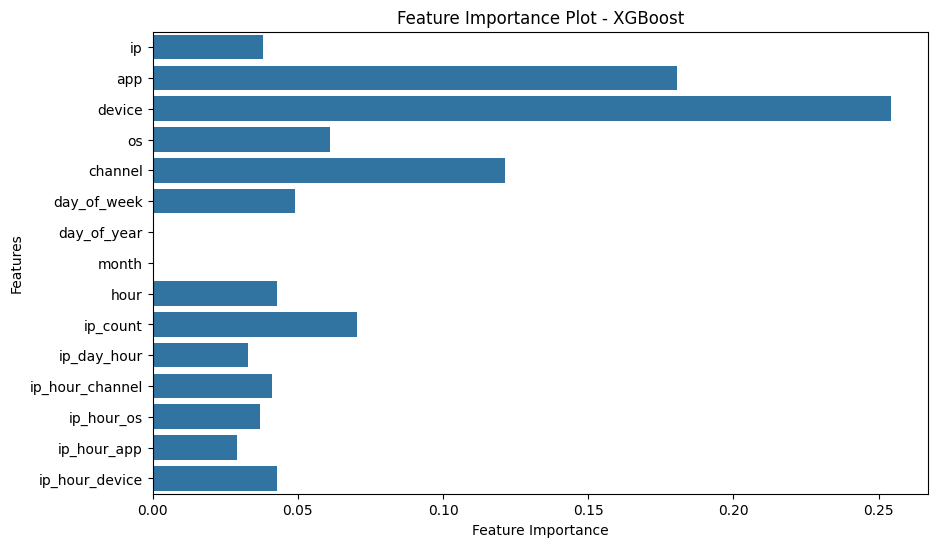

In [78]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Instantiate the XGBoost classifier
xgb_model = XGBClassifier()

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
predictions_xgb = xgb_model.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, predictions_xgb)
roc_auc_xgb = roc_auc_score(y_test, predictions_xgb)
classification_report_xgb = classification_report(y_test, predictions_xgb)

# Print the accuracy, ROC AUC, and classification report
print("XGBoost Classifier Accuracy:", accuracy_xgb)
print("XGBoost Classifier ROC AUC Score:", roc_auc_xgb)
print("Classification Report:")
print(classification_report_xgb)

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x=xgb_model.feature_importances_, y=X_train.columns)
plt.title('Feature Importance Plot - XGBoost')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()


Confusion Matrix

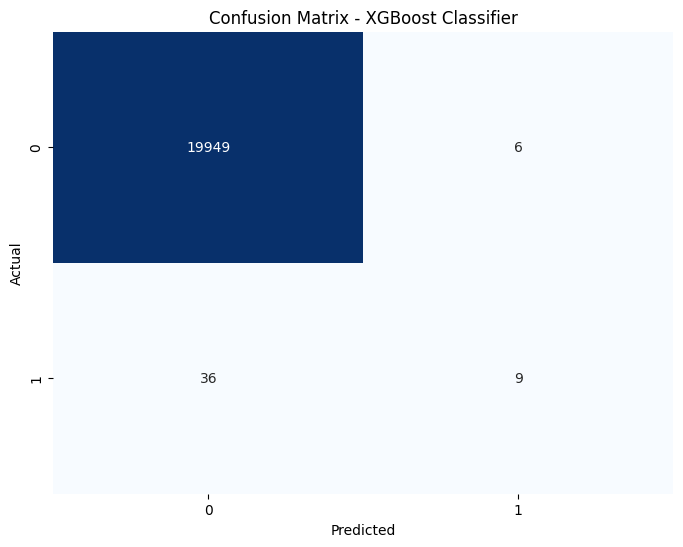

In [79]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm_xgb = confusion_matrix(y_test, predictions_xgb)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - XGBoost Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Receiver Operating Characteristic (ROC) Curve:

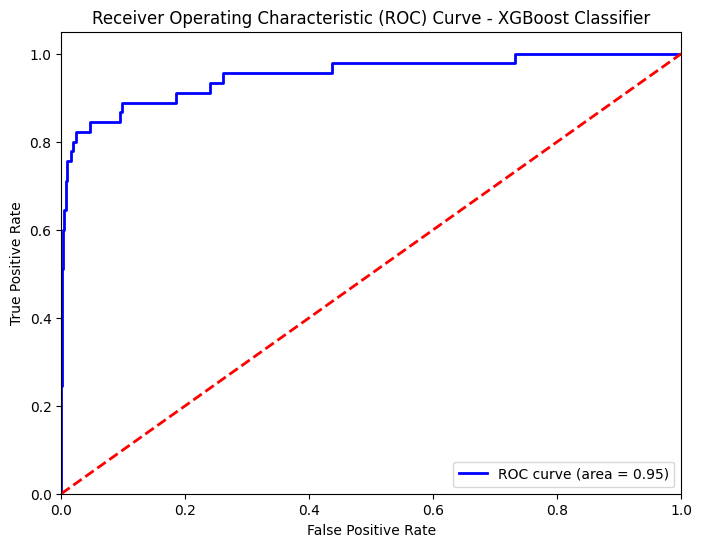

In [80]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute predicted probabilities
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
roc_auc_xgb = roc_auc_score(y_test, xgb_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost Classifier')
plt.legend(loc='lower right')
plt.show()


# **Random Forest Classifier:**

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Instantiate the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
rf_predictions = rf_classifier.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_roc_auc = roc_auc_score(y_test, rf_predictions)

print("Random Forest Classifier Accuracy:", rf_accuracy)
print("Random Forest Classifier ROC AUC Score:", rf_roc_auc)


Random Forest Classifier Accuracy: 0.99775
Random Forest Classifier ROC AUC Score: 0.5110860547342632


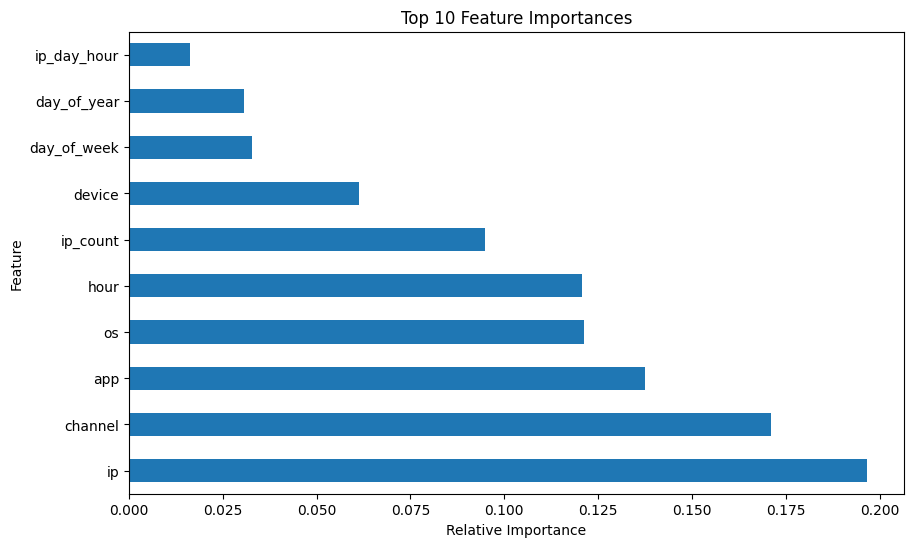

In [82]:
# Plot feature importances
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(rf_classifier.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.show()



Confusion Matrix:

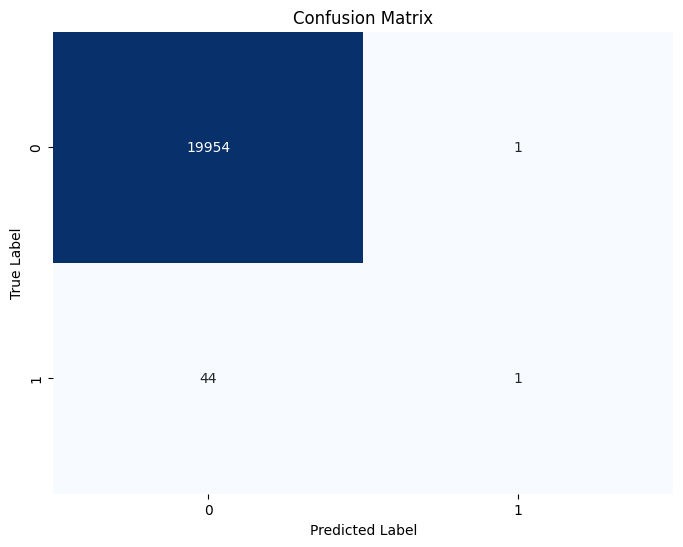

In [83]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, rf_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


 Receiver Operating Characteristic (ROC) Curve:

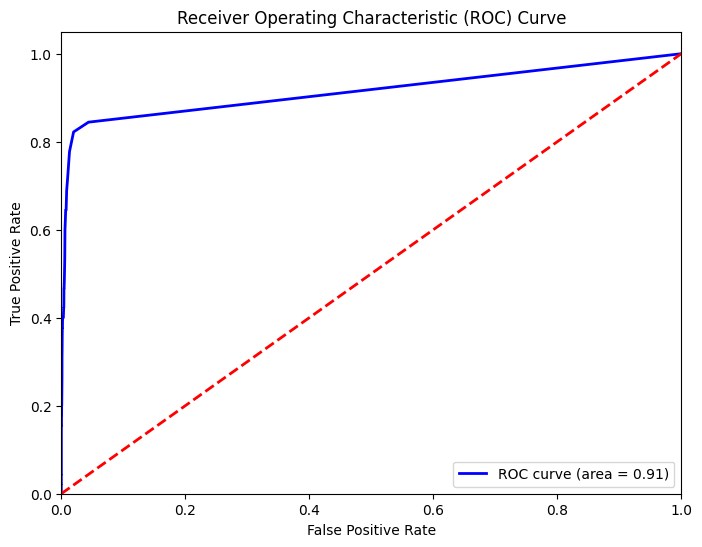

In [84]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute predicted probabilities
rf_probs = rf_classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, rf_probs)
roc_auc = roc_auc_score(y_test, rf_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Precision-Recall Curve:

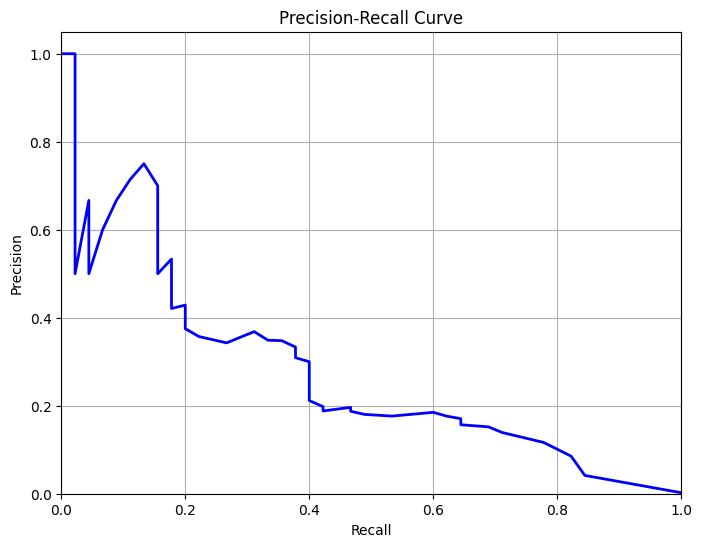

In [85]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, rf_probs)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()


Feature Importance:

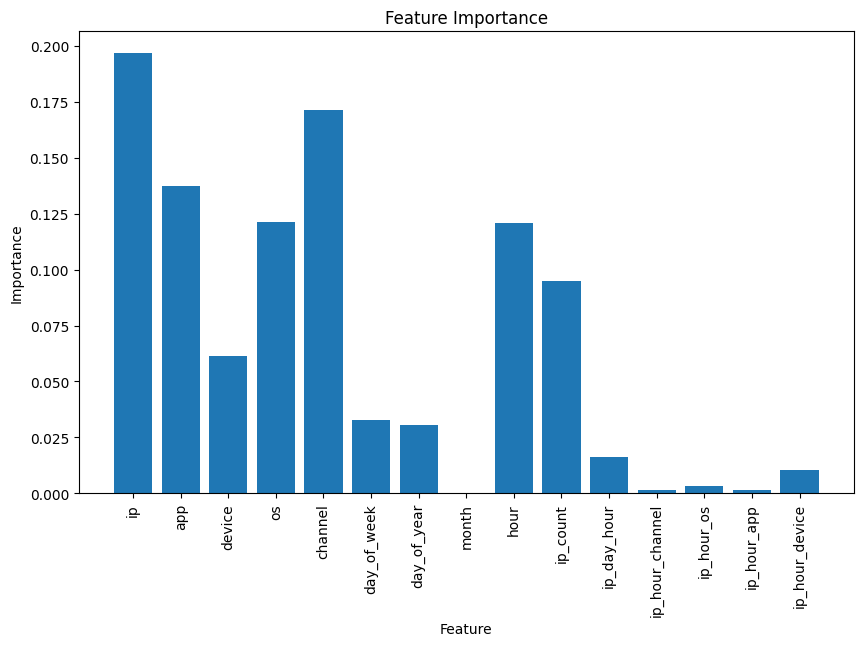

In [86]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, align='center')
plt.xticks(range(len(feature_importances)), X.columns, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


# **Support Vector Machine (SVM) Classifier**

In [87]:
from sklearn.svm import SVC

# Instantiate the SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Fit the model on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the test data
svm_predictions = svm_classifier.predict(X_test)

# Evaluate the model
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_roc_auc = roc_auc_score(y_test, svm_predictions)

print("SVM Classifier Accuracy:", svm_accuracy)
print("SVM Classifier ROC AUC Score:", svm_roc_auc)


SVM Classifier Accuracy: 0.997
SVM Classifier ROC AUC Score: 0.49962415434728136


In [88]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision_svm = precision_score(y_test, svm_predictions)
recall_svm = recall_score(y_test, svm_predictions)
f1_svm = f1_score(y_test, svm_predictions)

# Print the precision, recall, and F1-score
print("SVM Classifier Precision:", precision_svm)
print("SVM Classifier Recall:", recall_svm)
print("SVM Classifier F1-Score:", f1_svm)


SVM Classifier Precision: 0.0
SVM Classifier Recall: 0.0
SVM Classifier F1-Score: 0.0


Confusion Matrix:

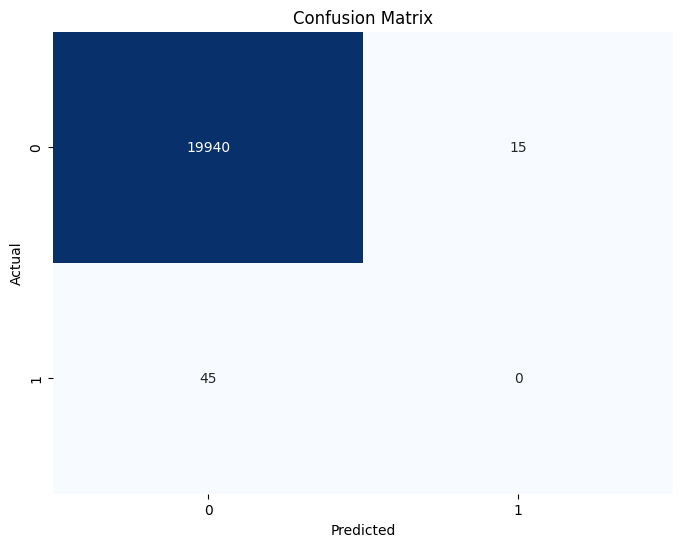

In [89]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, svm_predictions)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Receiver Operating Characteristic (ROC) Curve:

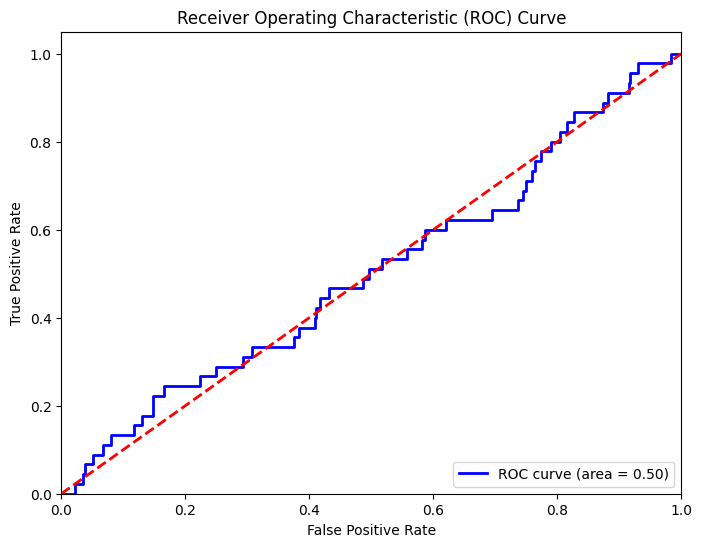

In [90]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute predicted probabilities
svm_probs = svm_classifier.decision_function(X_test)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, svm_probs)
roc_auc = roc_auc_score(y_test, svm_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Precision-Recall Curve:

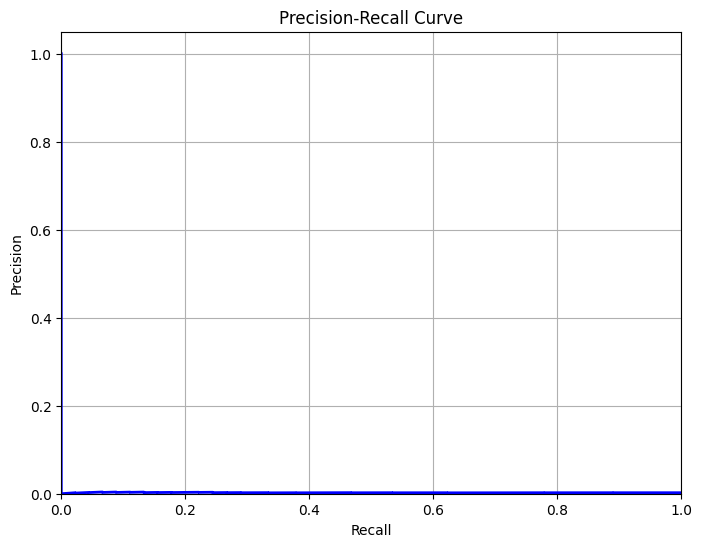

In [91]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, svm_probs)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()


# **Logistic Regression classifier:**

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Instantiate the Logistic Regression classifier
log_reg = LogisticRegression()

# Fit the model on the training data
log_reg.fit(X_train, y_train)

# Make predictions on the test data
predictions_lr = log_reg.predict(X_test)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, predictions_lr)
classification_report_lr = classification_report(y_test, predictions_lr)

# Print the accuracy and classification report
print("Logistic Regression Classifier Accuracy:", accuracy_lr)
print("Classification Report:")
print(classification_report_lr)


Logistic Regression Classifier Accuracy: 0.9977
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.00      0.00      0.00        45

    accuracy                           1.00     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       1.00      1.00      1.00     20000



Confusion Matrix:

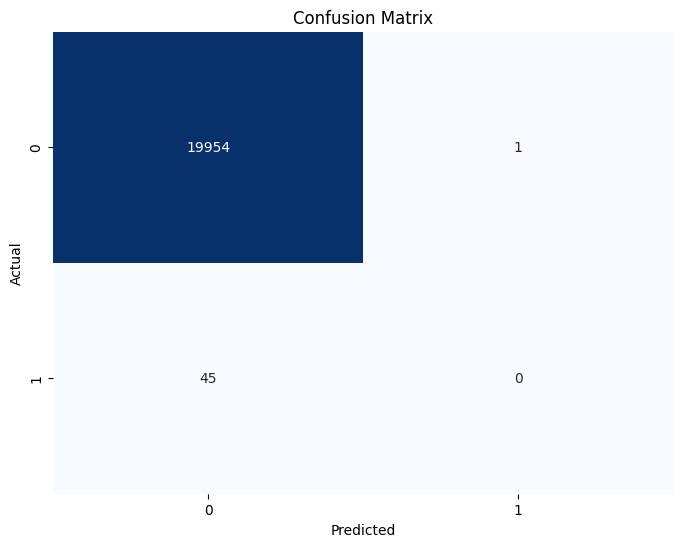

In [93]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions_lr)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


 Receiver Operating Characteristic (ROC) Curve:

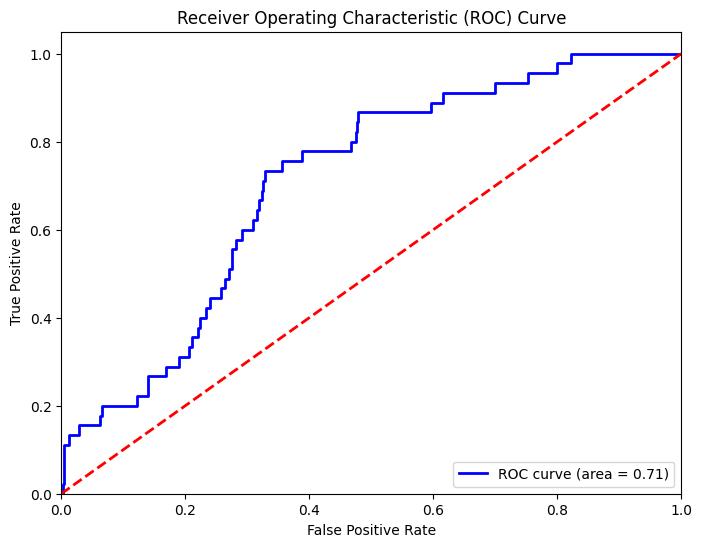

In [94]:
from sklearn.metrics import roc_curve, auc

# Compute predicted probabilities
y_probs_lr = log_reg.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_probs_lr)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Precision-Recall Curve:

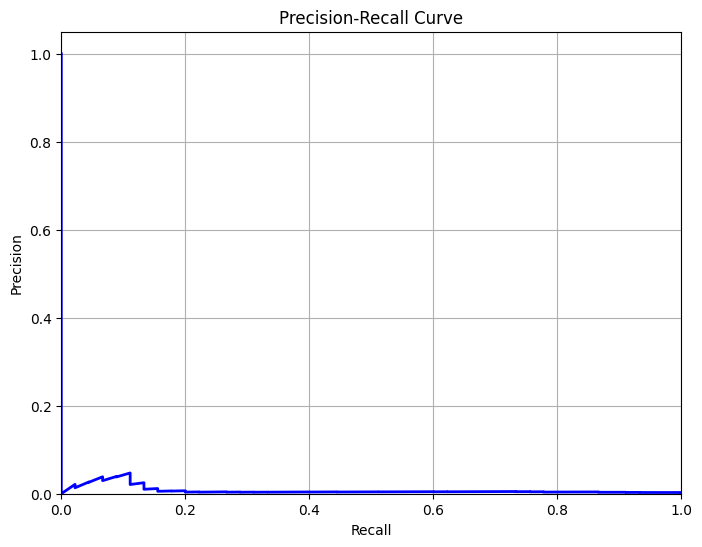

In [95]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_probs_lr)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()


Feature Importance

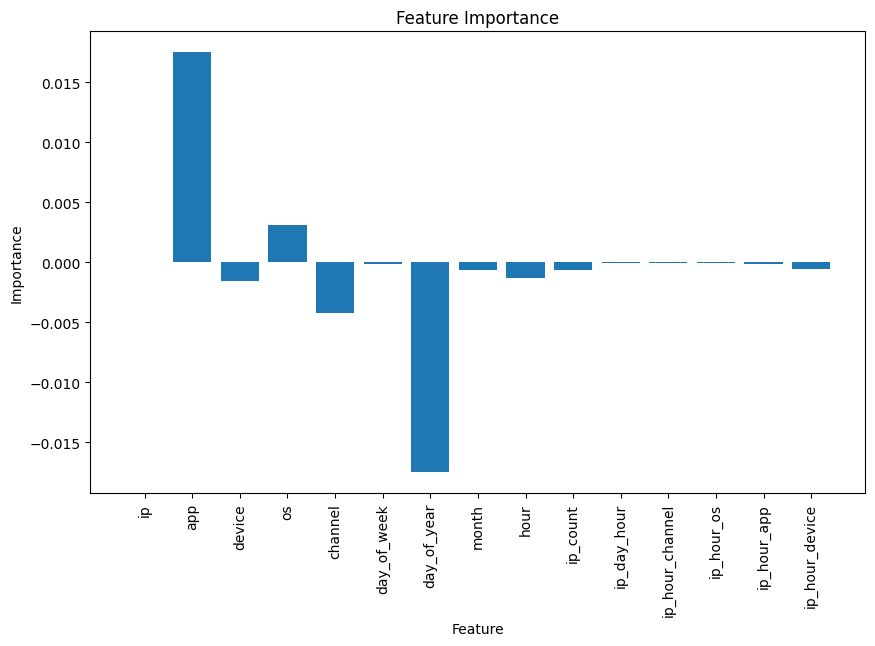

In [96]:
# Get feature importances
feature_importances = log_reg.coef_[0]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, align='center')
plt.xticks(range(len(feature_importances)), X.columns, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


# **Now lets try with balanced Data set **

# Randome forest after balanced


In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Instantiate the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the resampled training data
rf_classifier.fit(X_resampled, y_resampled)

# Make predictions on the test data
rf_predictions = rf_classifier.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_roc_auc = roc_auc_score(y_test, rf_predictions)

print("Random Forest Classifier Accuracy:", rf_accuracy)
print("Random Forest Classifier ROC AUC Score:", rf_roc_auc)


Random Forest Classifier Accuracy: 0.9976
Random Forest Classifier ROC AUC Score: 0.5220969403379827


In [98]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision_rf = precision_score(y_test, rf_predictions)
recall_rf = recall_score(y_test, rf_predictions)
f1_rf = f1_score(y_test, rf_predictions)

# Print the precision, recall, and F1-score
print("Random Forest Classifier Precision:", precision_rf)
print("Random Forest Classifier Recall:", recall_rf)
print("Random Forest Classifier F1-Score:", f1_rf)


Random Forest Classifier Precision: 0.2857142857142857
Random Forest Classifier Recall: 0.044444444444444446
Random Forest Classifier F1-Score: 0.07692307692307693


In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, average_precision_score
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Instantiate the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the resampled training data
rf_classifier.fit(X_resampled, y_resampled)

# Make predictions on the test data
rf_predictions = rf_classifier.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_roc_auc = roc_auc_score(y_test, rf_predictions)
classification_report_rf = classification_report(y_test, rf_predictions)
average_precision_rf = average_precision_score(y_test, rf_predictions)

# Print the accuracy, ROC AUC, classification report, and average precision
print("Random Forest Classifier Accuracy:", rf_accuracy)
print("Random Forest Classifier ROC AUC Score:", rf_roc_auc)
print("Classification Report:")
print(classification_report_rf)
print("Average Precision:", average_precision_rf)


Random Forest Classifier Accuracy: 0.9976
Random Forest Classifier ROC AUC Score: 0.5220969403379827
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.29      0.04      0.08        45

    accuracy                           1.00     20000
   macro avg       0.64      0.52      0.54     20000
weighted avg       1.00      1.00      1.00     20000

Average Precision: 0.014848412698412698


# Logistic Regression classifier after balanced

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Instantiate the Logistic Regression classifier
log_reg = LogisticRegression()

# Fit the model on the resampled training data
log_reg.fit(X_resampled, y_resampled)

# Make predictions on the test data
predictions_lr = log_reg.predict(X_test)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, predictions_lr)
classification_report_lr = classification_report(y_test, predictions_lr)

# Print the accuracy and classification report
print("Logistic Regression Classifier Accuracy:", accuracy_lr)
print("Classification Report:")
print(classification_report_lr)


Logistic Regression Classifier Accuracy: 0.99545
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.00      0.00      0.00        45

    accuracy                           1.00     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       1.00      1.00      1.00     20000



In [101]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision_lr = precision_score(y_test, predictions_lr)
recall_lr = recall_score(y_test, predictions_lr)
f1_lr = f1_score(y_test, predictions_lr)

# Print the precision, recall, and F1-score
print("Logistic Regression Classifier Precision:", precision_lr)
print("Logistic Regression Classifier Recall:", recall_lr)
print("Logistic Regression Classifier F1-Score:", f1_lr)


Logistic Regression Classifier Precision: 0.0
Logistic Regression Classifier Recall: 0.0
Logistic Regression Classifier F1-Score: 0.0


In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, average_precision_score
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Instantiate the Logistic Regression classifier
log_reg = LogisticRegression()

# Fit the model on the resampled training data
log_reg.fit(X_resampled, y_resampled)

# Make predictions on the test data
predictions_lr = log_reg.predict(X_test)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, predictions_lr)
classification_report_lr = classification_report(y_test, predictions_lr)
average_precision_lr = average_precision_score(y_test, predictions_lr)

# Print the accuracy, classification report, and average precision
print("Logistic Regression Classifier Accuracy:", accuracy_lr)
print("Classification Report:")
print(classification_report_lr)
print("Average Precision:", average_precision_lr)


Logistic Regression Classifier Accuracy: 0.99545
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.00      0.00      0.00        45

    accuracy                           1.00     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       1.00      1.00      1.00     20000

Average Precision: 0.00225


# Gradient Boosting classifier after balanced

Gradient Boosting Classifier Accuracy: 0.99565
Gradient Boosting Classifier ROC AUC Score: 0.60980817951502
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.16      0.22      0.19        45

    accuracy                           1.00     20000
   macro avg       0.58      0.61      0.59     20000
weighted avg       1.00      1.00      1.00     20000



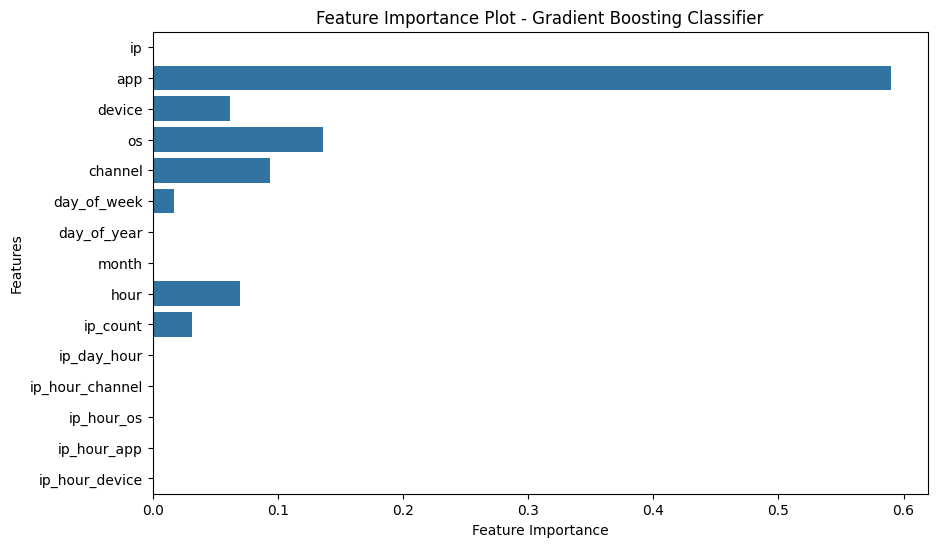

In [103]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Instantiate the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier()

# Fit the model on the resampled training data
gb_classifier.fit(X_resampled, y_resampled)

# Make predictions on the test data
predictions_gb = gb_classifier.predict(X_test)

# Evaluate the model
accuracy_gb = accuracy_score(y_test, predictions_gb)
roc_auc_gb = roc_auc_score(y_test, predictions_gb)
classification_report_gb = classification_report(y_test, predictions_gb)

# Print the accuracy, ROC AUC, and classification report
print("Gradient Boosting Classifier Accuracy:", accuracy_gb)
print("Gradient Boosting Classifier ROC AUC Score:", roc_auc_gb)
print("Classification Report:")
print(classification_report_gb)

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x=gb_classifier.feature_importances_, y=X_train.columns)
plt.title('Feature Importance Plot - Gradient Boosting Classifier')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()


In [104]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision_gb = precision_score(y_test, predictions_gb)
recall_gb = recall_score(y_test, predictions_gb)
f1_gb = f1_score(y_test, predictions_gb)

# Print the precision, recall, and F1-score
print("Gradient Boosting Classifier Precision:", precision_gb)
print("Gradient Boosting Classifier Recall:", recall_gb)
print("Gradient Boosting Classifier F1-Score:", f1_gb)


Gradient Boosting Classifier Precision: 0.16129032258064516
Gradient Boosting Classifier Recall: 0.2222222222222222
Gradient Boosting Classifier F1-Score: 0.1869158878504673


In [105]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, average_precision_score
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Instantiate the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier()

# Fit the model on the resampled training data
gb_classifier.fit(X_resampled, y_resampled)

# Make predictions on the test data
predictions_gb = gb_classifier.predict(X_test)

# Evaluate the model
accuracy_gb = accuracy_score(y_test, predictions_gb)
roc_auc_gb = roc_auc_score(y_test, predictions_gb)
classification_report_gb = classification_report(y_test, predictions_gb)
average_precision_gb = average_precision_score(y_test, predictions_gb)

# Print the accuracy, ROC AUC, classification report, and average precision
print("Gradient Boosting Classifier Accuracy:", accuracy_gb)
print("Gradient Boosting Classifier ROC AUC Score:", roc_auc_gb)
print("Classification Report:")
print(classification_report_gb)
print("Average Precision:", average_precision_gb)


Gradient Boosting Classifier Accuracy: 0.99565
Gradient Boosting Classifier ROC AUC Score: 0.60980817951502
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.16      0.22      0.19        45

    accuracy                           1.00     20000
   macro avg       0.58      0.61      0.59     20000
weighted avg       1.00      1.00      1.00     20000

Average Precision: 0.037592293906810036


# AdaBoosting after balanced

In [106]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Instantiate the AdaBoost Classifier
ada_classifier = AdaBoostClassifier()

# Fit the model on the resampled training data
ada_classifier.fit(X_resampled, y_resampled)

# Make predictions on the test data
predictions_ada = ada_classifier.predict(X_test)

# Evaluate the model
accuracy_ada = accuracy_score(y_test, predictions_ada)
roc_auc_ada = roc_auc_score(y_test, predictions_ada)
classification_report_ada = classification_report(y_test, predictions_ada)

# Print the accuracy, ROC AUC, and classification report
print("AdaBoost Classifier Accuracy:", accuracy_ada)
print("AdaBoost Classifier ROC AUC Score:", roc_auc_ada)
print("Classification Report:")
print(classification_report_ada)


AdaBoost Classifier Accuracy: 0.99615
AdaBoost Classifier ROC AUC Score: 0.6433169074862886
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.22      0.29      0.25        45

    accuracy                           1.00     20000
   macro avg       0.61      0.64      0.63     20000
weighted avg       1.00      1.00      1.00     20000



In [107]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision_ada = precision_score(y_test, predictions_ada)
recall_ada = recall_score(y_test, predictions_ada)
f1_ada = f1_score(y_test, predictions_ada)

# Print the precision, recall, and F1-score
print("AdaBoost Classifier Precision:", precision_ada)
print("AdaBoost Classifier Recall:", recall_ada)
print("AdaBoost Classifier F1-Score:", f1_ada)


AdaBoost Classifier Precision: 0.22413793103448276
AdaBoost Classifier Recall: 0.28888888888888886
AdaBoost Classifier F1-Score: 0.2524271844660194


In [108]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, average_precision_score
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Instantiate the AdaBoost Classifier
ada_classifier = AdaBoostClassifier()

# Fit the model on the resampled training data
ada_classifier.fit(X_resampled, y_resampled)

# Make predictions on the test data
predictions_ada = ada_classifier.predict(X_test)

# Evaluate the model
accuracy_ada = accuracy_score(y_test, predictions_ada)
roc_auc_ada = roc_auc_score(y_test, predictions_ada)
classification_report_ada = classification_report(y_test, predictions_ada)
average_precision_ada = average_precision_score(y_test, predictions_ada)

# Print the accuracy, ROC AUC, classification report, and average precision
print("AdaBoost Classifier Accuracy:", accuracy_ada)
print("AdaBoost Classifier ROC AUC Score:", roc_auc_ada)
print("Classification Report:")
print(classification_report_ada)
print("Average Precision:", average_precision_ada)


AdaBoost Classifier Accuracy: 0.99615
AdaBoost Classifier ROC AUC Score: 0.6433169074862886
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.22      0.29      0.25        45

    accuracy                           1.00     20000
   macro avg       0.61      0.64      0.63     20000
weighted avg       1.00      1.00      1.00     20000

Average Precision: 0.06635095785440613


# XGBOOST after ballancing

In [109]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Instantiate the XGBoost Classifier
xgb_classifier = xgb.XGBClassifier()

# Fit the model on the resampled training data
xgb_classifier.fit(X_resampled, y_resampled)

# Make predictions on the test data
predictions_xgb = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, predictions_xgb)
roc_auc_xgb = roc_auc_score(y_test, predictions_xgb)
classification_report_xgb = classification_report(y_test, predictions_xgb)

# Print the accuracy, ROC AUC, and classification report
print("XGBoost Classifier Accuracy:", accuracy_xgb)
print("XGBoost Classifier ROC AUC Score:", roc_auc_xgb)
print("Classification Report:")
print(classification_report_xgb)


XGBoost Classifier Accuracy: 0.99715
XGBoost Classifier ROC AUC Score: 0.6216459255547203
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.32      0.24      0.28        45

    accuracy                           1.00     20000
   macro avg       0.66      0.62      0.64     20000
weighted avg       1.00      1.00      1.00     20000



In [110]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision_xgb = precision_score(y_test, predictions_xgb)
recall_xgb = recall_score(y_test, predictions_xgb)
f1_xgb = f1_score(y_test, predictions_xgb)

# Print the precision, recall, and F1-score
print("XGBoost Classifier Precision:", precision_xgb)
print("XGBoost Classifier Recall:", recall_xgb)
print("XGBoost Classifier F1-Score:", f1_xgb)


XGBoost Classifier Precision: 0.3235294117647059
XGBoost Classifier Recall: 0.24444444444444444
XGBoost Classifier F1-Score: 0.27848101265822783


In [111]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, average_precision_score
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Instantiate the XGBoost Classifier
xgb_classifier = xgb.XGBClassifier()

# Fit the model on the resampled training data
xgb_classifier.fit(X_resampled, y_resampled)

# Make predictions on the test data
predictions_xgb = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, predictions_xgb)
roc_auc_xgb = roc_auc_score(y_test, predictions_xgb)
classification_report_xgb = classification_report(y_test, predictions_xgb)
average_precision_xgb = average_precision_score(y_test, predictions_xgb)

# Print the accuracy, ROC AUC, classification report, and average precision
print("XGBoost Classifier Accuracy:", accuracy_xgb)
print("XGBoost Classifier ROC AUC Score:", roc_auc_xgb)
print("Classification Report:")
print(classification_report_xgb)
print("Average Precision:", average_precision_xgb)


XGBoost Classifier Accuracy: 0.99715
XGBoost Classifier ROC AUC Score: 0.6216459255547203
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19955
           1       0.32      0.24      0.28        45

    accuracy                           1.00     20000
   macro avg       0.66      0.62      0.64     20000
weighted avg       1.00      1.00      1.00     20000

Average Precision: 0.08078496732026143


# **"Majority Voting Algorithm**

In [115]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Step 1: Load and preprocess your dataset
# Assuming you have already loaded your dataset into X and y
# Example: X, y = load_data()

# Step 2: Split your dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Define the individual classifiers
log_reg = LogisticRegression(solver='liblinear')
tree = DecisionTreeClassifier()
svm_clf = SVC(gamma='scale')

# Step 4: Create the VotingClassifier
estimators = [('Logistic', log_reg), ('Tree', tree), ('SVM', svm_clf)]
voting = VotingClassifier(estimators=estimators)

# Step 5: Fit the ensemble model
voting.fit(X_train, y_train)

# Step 6: Evaluate the model
# Training Results
train_predictions = voting.predict(X_train)
train_confusion_matrix = confusion_matrix(y_train, train_predictions)
train_accuracy = accuracy_score(y_train, train_predictions)
train_classification_report = classification_report(y_train, train_predictions)

# Testing Results
test_predictions = voting.predict(X_test)
test_confusion_matrix = confusion_matrix(y_test, test_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)
test_classification_report = classification_report(y_test, test_predictions)

# Step 7: Print the results
print("Under training results:")
print("Confusion Matrix:")
print(train_confusion_matrix)
print("Accuracy Score:", train_accuracy)
print("Classification Report:")
print(train_classification_report)

print("\nUnder testing results:")
print("Confusion Matrix:")
print(test_confusion_matrix)
print("Accuracy Score:", test_accuracy)
print("Classification Report:")
print(test_classification_report)


Under training results:
Confusion Matrix:
[[79824     0]
 [  176     0]]
Accuracy Score: 0.9978
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79824
           1       0.00      0.00      0.00       176

    accuracy                           1.00     80000
   macro avg       0.50      0.50      0.50     80000
weighted avg       1.00      1.00      1.00     80000


Under testing results:
Confusion Matrix:
[[19949     0]
 [   51     0]]
Accuracy Score: 0.99745
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19949
           1       0.00      0.00      0.00        51

    accuracy                           1.00     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.99      1.00      1.00     20000

